# Python Group
## Lab Assignment Six: Convolutional Network Architectures
### Wali Chaudhary, Bryce Shurts, & Alex Wright

## 1. Business Understanding

Our dataset is composed of MRI images of brains with labels indicating whether the brain has a cancerous tumor or is normal. All images are black and white, but are composed of different image types, formats, and resolutions. Each image is labeled as cancerous or normal. The MRI scan may be top down or from a side profile perspective. The purpose of this dataset is to help automate the identification of cancerous tumors from a vast quantity of data generated by the MRI machine which generates an image for each "slice" of the three dimensional object placed inside through use of magnetic resonance. This data is important as the process of identifying a cancerous tumor is a vast quantity of MRI data can be tedious and error prone. Automating the discovery of a tumor can help a doctor zero in on specific portions of the data for review, may detect tumors a doctor may have missed, and generally assist with the procedure of analyzing MRI data. Since medical data will be reviewed by a doctor regardless of the outcome of the classifier, less than perfect results may still be helpful in diagnosis.

### Citation & Acknowledgement
The Brain Tumor Data Set dataset is licensed under the [GNU General Public License, version 2](https://www.gnu.org/licenses/old-licenses/gpl-2.0.en.html) and was provided by Preet Viradiya on [Kaggle](https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset).

In [1]:
# Handle all imports for notebook
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import numpy as np
from numpy import expand_dims
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from os import listdir
from os.path import isfile, join
from skimage.transform import resize
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics as mt
import pprint
from matplotlib import pyplot as plt
from keras.layers import Dense, Activation, Input
from keras.models import Model
from keras.models import Sequential
from keras.utils import plot_model
from keras.layers import Embedding
from keras.layers import concatenate
from sklearn.model_selection import train_test_split
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.utils import img_to_array
from sklearn.metrics import roc_curve, auc
from keras.preprocessing.image import ImageDataGenerator


print("Tensorflow version:", tf.__version__)
print("Keras version:", keras.__version__)

Tensorflow version: 2.11.1
Keras version: 2.11.0


In [2]:
df: DataFrame = pd.read_csv("metadata.csv")
df.head()

,Unnamed: 0,image,class,format,mode,shape
0,0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"


Immediately we can see that we have an unnamed title with a set of IDs, which can be safely removed

In [3]:
df.drop("Unnamed: 0", axis=1, inplace=True)
df.head()

,image,class,format,mode,shape
0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"


#### Resolutions by Count
It looks like the images are not particularly uniform in composition. Let's investigate further.

Resolutions by count:
 (512, 512, 3)    884
(225, 225, 3)    364
(630, 630, 3)    126
(256, 256, 3)    105
(236, 236, 3)     89
(251, 201, 3)     80
(217, 232, 3)     53
(168, 300, 3)     52
(221, 228, 3)     51
(198, 150, 3)     45
(252, 200, 3)     44
(417, 428, 3)     43
(222, 227, 3)     40
(201, 173, 3)     38
(244, 206, 3)     38
(442, 442, 3)     34
(192, 192, 3)     32
(250, 201, 3)     31
(231, 218, 3)     31
(234, 215, 3)     28
Name: shape, dtype: int64


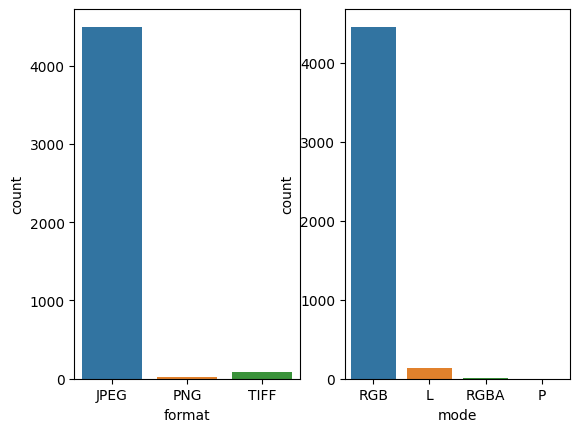

In [4]:
fig, ax = plt.subplots(1,2)
sns.countplot(x="format", data=df, ax=aimages[0])
sns.countplot(x="mode", data=df, ax=aimages[1])
print("Resolutions by count:\n", df["shape"].value_counts()[0:20])
# Way too many resolutions to plot...
#sns.countplot(x="shape", data=df, ax=aimages[2])
plt.show()

We can see that we have a few different images that are not in the JPEG format and/or are not using the RGB or L (grayscale) color mode, which are both the most common. Since conversions would be computationally expensive and lossy, and since the number of images that are in the wrong format is relatively few, they will be dropped.
Resolutions will also be restricted to the largest square images in the top 20 most frequent resolutions, with all images to be downscaled to the smallest image to avoid losing data in trying to upscale (shown to be worse than downscaling by [this article](https://medium.com/neuronio/how-to-deal-with-image-resizing-in-deep-learning-e5177fad7d89).

In [4]:
# First we identify undesirable images
# TODO: convert RGBA to RGB?
bad_columns = df[(df["format"] != "JPEG") | (df["mode"] != "RGB") |
                 ((df["shape"] != "(630, 630, 3)")
                  & (df["shape"] != "(512, 512, 3)")
                  & (df["shape"] != "(442, 442, 3)")
                  & (df["shape"] != "(256, 256, 3)")
                  & (df["shape"] != "(236, 236, 3)")
                  & (df["shape"] != "(225, 225, 3)")
                  & (df["shape"] != "(192, 192, 3)"))]
df.drop(bad_columns.index, inplace=True)
bad_columns = bad_columns["image"] # For later deletion

In [5]:
# Then we remove images we don't want to convert or otherwise process
# We could import the images first and then delete from the numpy arrays to preserve the github dataset, but that's a lot of wasted time & space.
files = [file for file in listdir("Brain Tumor Data Set/Brain Tumor/") if isfile(join("Brain Tumor Data Set/Brain Tumor/", file))] + [file for file in listdir("Brain Tumor Data Set/Healthy/") if isfile(join("Brain Tumor Data Set/Healthy/", file))]
bad_files = [file for file in files if file in bad_columns.tolist()]
for file in bad_files:
    if "Not" in file:
        os.remove(join("Brain Tumor Data Set/Healthy/", file))
    else:
        os.remove(join("Brain Tumor Data Set/Brain Tumor/", file))

In [6]:
# Confirm we still have more than 1000 images
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1548 entries, 0 to 4585
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   1548 non-null   object
 1   class   1548 non-null   object
 2   format  1548 non-null   object
 3   mode    1548 non-null   object
 4   shape   1548 non-null   object
dtypes: object(5)
memory usage: 72.6+ KB


## Data Augmentation
In order to try and improve detection preformance, we will be taking our grayscale images and randomly varying the brightness via a data augmentation: the tumors often come in the form of a dark lump on CT scans, so varying the brightness should, intuitively, increase the F1 score (better true positive rate) of our models by providing a variety of images where the tumor is correspondingly more or less difficult to identify (a dark image would be very difficult, for instance). This should, in turn, provide a more generalized classifier that is less sensitive to brightness and relative contrast.

In [7]:
datagen = ImageDataGenerator(brightness_range=[0.2, 0.8])

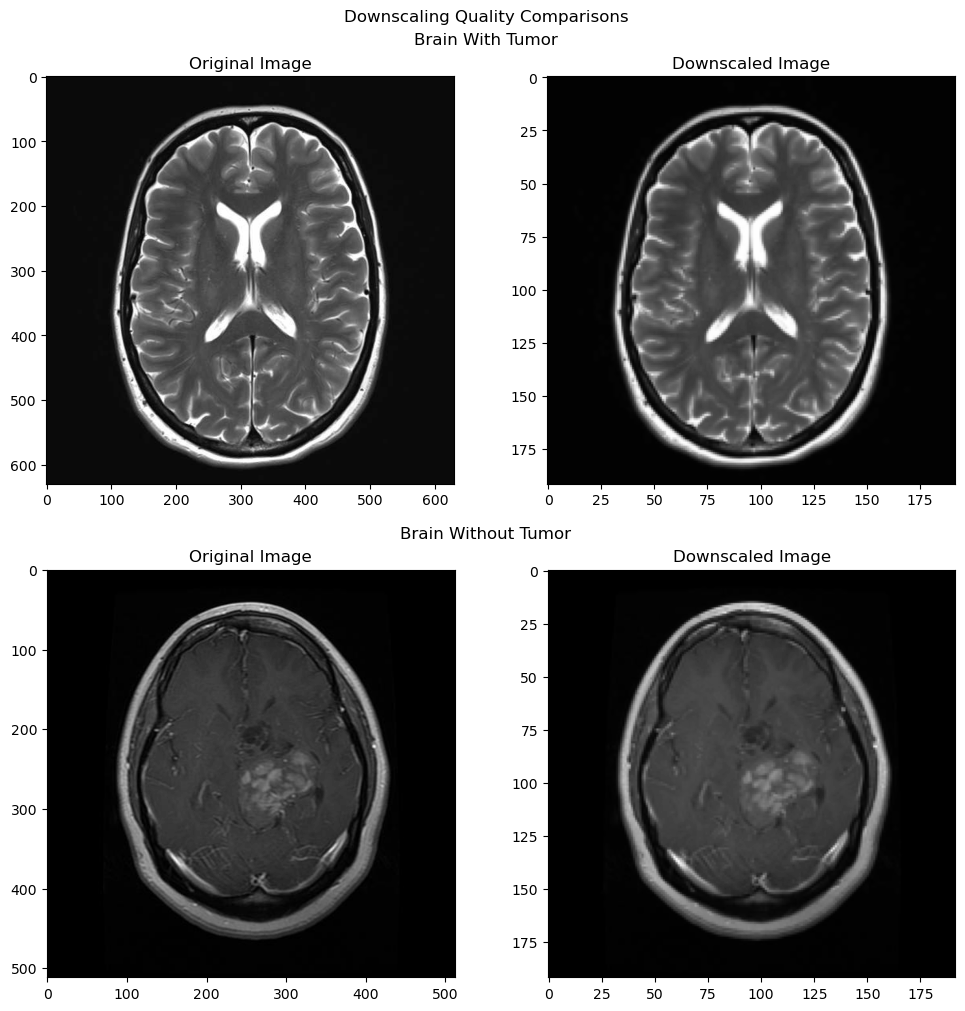

In [8]:
# Now import each image as a numpy array & do the final conversion of their resolutions
# Thoughts on what to do with resolutions? I say convert all to the smallest dimension (225x225)
cancer_images = []
healthy_images = []
original_images = [file for file in listdir("Brain Tumor Data Set/Brain Tumor/") if isfile(join("Brain Tumor Data Set/Brain Tumor/", file))] + [file for file in listdir("Brain Tumor Data Set/Healthy/") if isfile(join("Brain Tumor Data Set/Healthy/", file))]
for image in original_images:
    if "Not" in image:
        img = Image.open(join("Brain Tumor Data Set/Healthy/", image)).convert('L')
        img = img_to_array(img)
        img = datagen.flow(expand_dims(img, 0), batch_size=1, save_to_dir=join("Brain Tumor Data Set/Healthy/", image), save_format="jpeg")
        cancer_images.append(plt.imread(join("Brain Tumor Data Set/Healthy/", image)))
    else:
        img = Image.open(join("Brain Tumor Data Set/Brain Tumor/", image)).convert('L')
        img = img_to_array(img)
        img = datagen.flow(expand_dims(img, 0), batch_size=1, save_to_dir=join("Brain Tumor Data Set/Brain Tumor/", image), save_format="jpeg")
        healthy_images.append(plt.imread(join("Brain Tumor Data Set/Brain Tumor/", image)))

images = []
targets = []
for image_set in (cancer_images, healthy_images): 
    for image in image_set:
        # Healthy
        if len(image_set) == 576:
            targets.append(1)
        # Cancer
        else:
            targets.append(0)
        # Apply the resizing non-uniformly since evidently it affects images
        # even if they're the same size as the target resolution.
        # Difference with Linear PCA was:
        #   Applied to every image:
        #     233 components with λ > 1 for 92% explanation
        #   Applied to mis-sized images:
        #     256 components with λ > 1 for 99% explanation
        
        #images.append(resize(image, (192, 192), anti_aliasing=True).flatten())
        if len(image) != 192:
            resized = resize(image, (192, 192), anti_aliasing=True)
            #print(resized.shape)
            images.append(resized)
        else:
            #print(image.shape)
            images.append(image)
images = np.array(images)
targets = np.array(targets)

fig = plt.figure(constrained_layout=True, figsize=(10,10))
fig.suptitle("Downscaling Quality Comparisons")
subfigs = fig.subfigures(2, 1)
ax_cancer = subfigs[0].subplots(1, 2)
subfigs[0].suptitle("Brain With Tumor")
ax_cancer[0].imshow(cancer_images[0], cmap='gray')
ax_cancer[0].set_title("Original Image")
ax_cancer[1].imshow(images[0].reshape(192, 192, 1), cmap='gray')
ax_cancer[1].set_title("Downscaled Image")
ax_healthy = subfigs[1].subplots(1, 2)
subfigs[1].suptitle("Brain Without Tumor")
ax_healthtargets[0].imshow(healthy_images[0], cmap='gray')
ax_healthtargets[0].set_title("Original Image")
ax_healthtargets[1].imshow(images[len(cancer_images)].reshape(192, 192, 1), cmap='gray')
ax_healthtargets[1].set_title("Downscaled Image")
plt.show()

## Preparation

#### Measurements Chosen

Ultimately, we chose the F1 score as our performance metric for the models. There are several factors we had to take to chose our performance metric for this particular task for the identification of Brain Tumors vs Healthy brains.

First, we had to consider the nature of the task at hand, which is classifying tumors in brains. Because this is a task with a high cost of misclassification, it is important for us to choose a performance metric which takes into account the trade-off between false positives and false negatives, and because the F1 score is the harmonic mean of precision and recall, it allows us to evaluate our model's ability to identify each class correctly and minimize both false positives and false negatives. This will ultimately help us choose the best model with the lowest false positive and false negative rates.

Secondly, initially we had many numerous image resolutions (see the Resolution by Count subsection above), each with varying degrees of frequency of images. Although we resolved this issue by dropping certain image resolutions until we only had 6 and also removed any images that were not JPEG or in RGB which made the data more uniform, there is still a high chance of an imbalanced class distribution. This is a problem because the model might perform well on the majority class but perform poorly on a minority class, but still achieve high accuracy. This is also another reason to use an additional metric such as the F1 score to give us further insight into model performance.

In addition to the F1-score, we will use a confusion matrix to visualize the performance of our model. This will provide insights into the specific misclassifications made by the model, helping us understand its strengths and weaknesses across different classes.

#### Dividing Data

We will use Stratified Shuffle Split so that we can preserve class distribution, meaning that we can preserve proportionality per class in our training and testing splits. It also allows us to introduce a degree of randomization in the data splitting process, reducing the probability of overfitting and helps our model generalize better. We can also specify the proportion we want to split by, so this gives us some additional flexibility and an additional parameter for us to experiment with finding the ideal test-train data proportional split. Given the additional randomization componenet of Stratified Shuffle Split, it mirrors the real world better because our model will encounter random

In [9]:
# Define the Stratified Shuffle Split object
n_splits = 3
test_size = 0.2
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=42)   

## CNN

In [10]:
%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test, labels='auto'):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(X_test), axis=1)
        acc_cnn = mt.f1_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title('CNN: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.f1_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title('MLP: '+str(acc_mlp))

In [17]:
%%time

NUM_CLASSES = 2

# Initialize lists to store the true and predicted labels and the ROC curve data\n",
y_true_list = []
yhat_list = []
fpr_list = []
tpr_list = []
auc_list = []

# make a 3 layer keras MLP
mlp = Sequential()
mlp.add( Flatten() ) # make images flat for the MLP input
mlp.add( Dense(input_dim=1, units=30, 
               activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

for train_index, test_index in sss.split(images, targets):
    X_train, X_test = images[train_index], images[test_index]
    y_train, y_test = targets[train_index], targets[test_index]
    
    mlp.fit(X_train, y_train, 
            batch_size=32, epochs=50, 
            shuffle=False, verbose=False)
    
    yhat_proba = mlp.predict(X_test)
    final_yhat = []
    for sample in yhat_proba:
        if sample[0] > sample[1]:
            final_yhat.append(sample[0])
        else:
            final_yhat.append(sample[1])
    # Compute the ROC curve and AUC for the current fold
    fpr, tpr, thresholds = roc_curve(y_test, final_yhat)
    roc_auc = auc(fpr, tpr)

    # Append the true labels, predicted probabilities, and ROC curve data to the lists
    y_true_list.append(y_test)
    yhat_list.append(final_yhat)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(roc_auc)

10/10 [==============================] - 0s 3ms/step
CPU times: user 34.9 s, sys: 7.71 s, total: 42.6 s
Wall time: 23.1 s


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 36864)             0         
                                                                 
 dense_12 (Dense)            (None, 30)                1105950   
                                                                 
 dense_13 (Dense)            (None, 15)                465       
                                                                 
 dense_14 (Dense)            (None, 2)                 32        
                                                                 
 activation_4 (Activation)   (None, 2)                 0         
                                                                 
Total params: 1,106,447
Trainable params: 1,106,447
Non-trainable params: 0
_________________________________________________________________


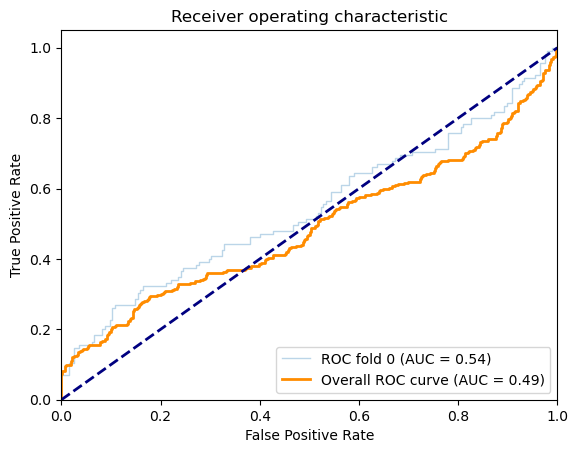

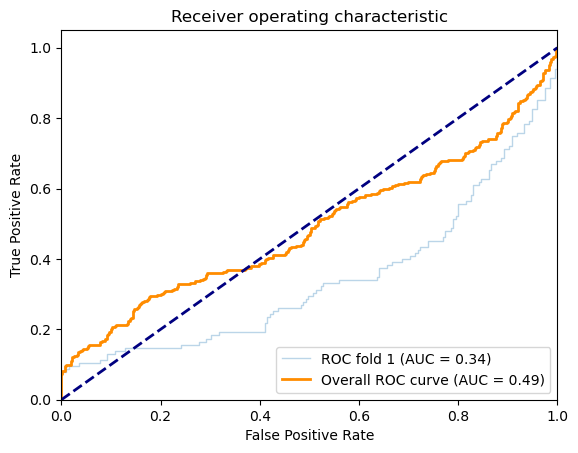

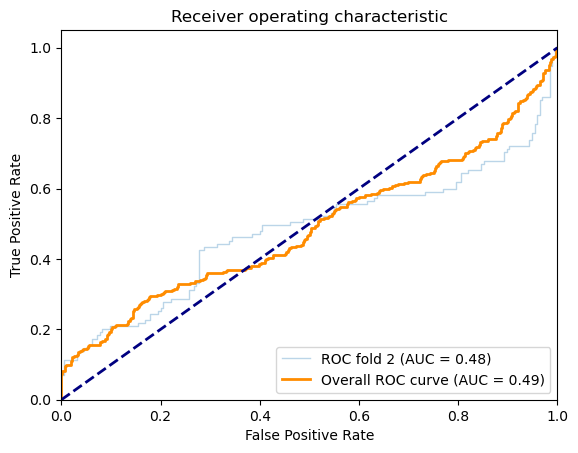

In [18]:
mlp.summary()
# Compute the overall ROC curve and AUC for all the folds
y_true = np.concatenate(y_true_list)
y_proba = np.concatenate(yhat_list)
fpr, tpr, thresholds = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve for each fold and the overall ROC curve
plt.figure()
for i in range(len(fpr_list)):
    plt.plot(fpr_list[i], tpr_list[i], lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, auc_list[i]))
    plt.plot(fpr, tpr, lw=2, color='darkorange', label='Overall ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 16)      80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 16)       0         
 )                                                               
                                                                 
 activation_5 (Activation)   (None, 96, 96, 16)        0         
                                                                 
 flatten_5 (Flatten)         (None, 147456)            0         
                                                                 
 dense_15 (Dense)            (None, 2)                 294914    
                                                                 
 activation_6 (Activation)   (None, 2)                 0         
                                                      

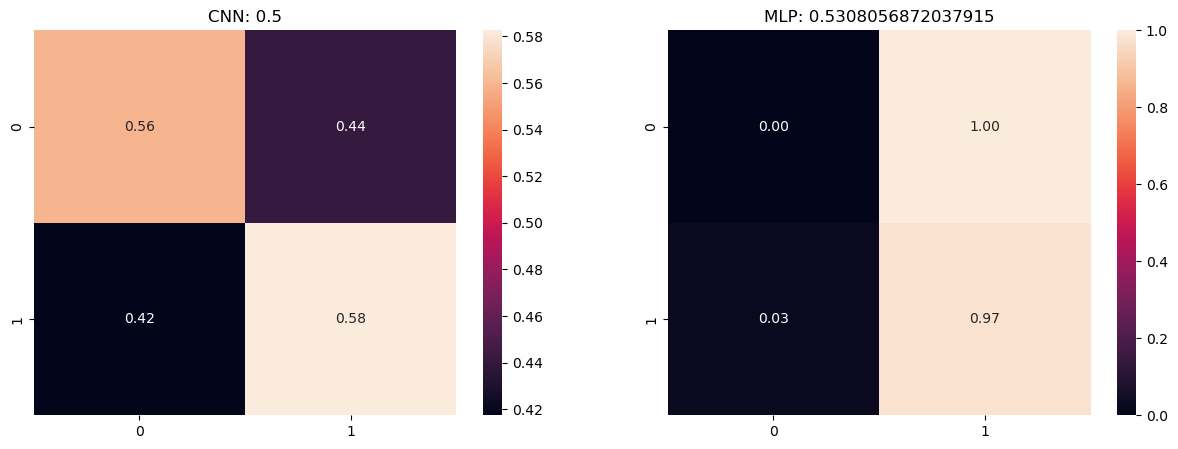

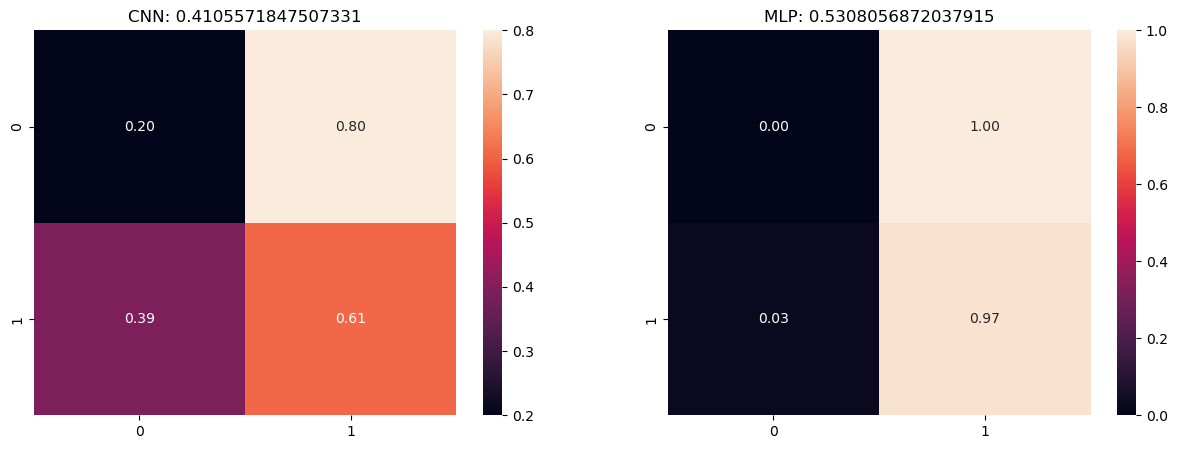

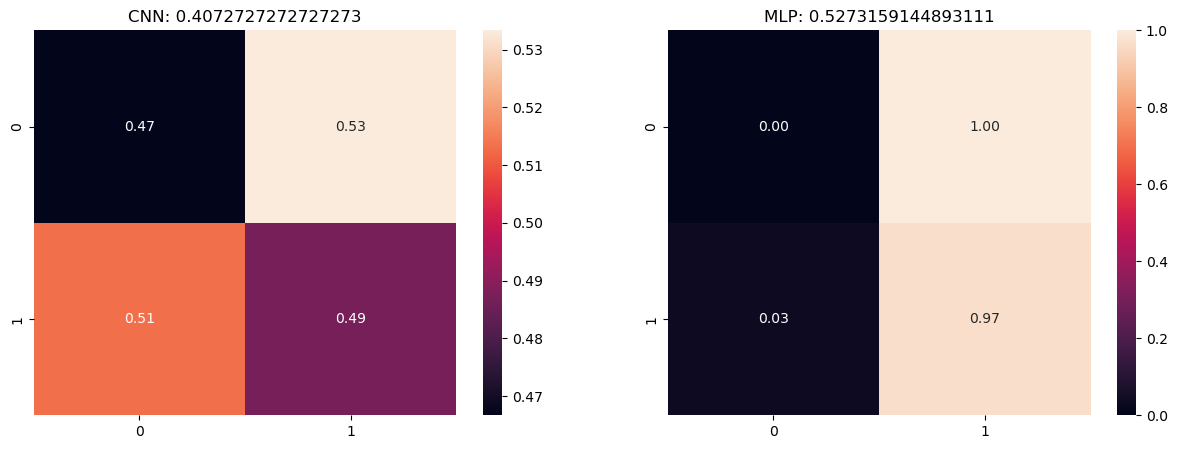

In [19]:
%%time

# Initialize lists to store the true and predicted labels and the ROC curve data\n",
y_true_list = []
yhat_list = []
fpr_list = []
tpr_list = []
auc_list = []

# make a CNN with conv layer and max pooling
cnn = Sequential() 
cnn.add( Conv2D(filters=16, kernel_size= (2, 2), padding='same', 
                input_shape=(192,192,1),
               ) )

cnn.add( MaxPooling2D(pool_size=(2, 2)) )
cnn.add( Activation('relu') )
# add one layer on flattened output
cnn.add( Flatten() )
cnn.add( Dense(NUM_CLASSES) )
cnn.add( Activation('softmax') )

cnn.summary()

# Let's train the model 
cnn.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

for train_index, test_index in sss.split(images, targets):
    X_train, X_test = images[train_index], images[test_index]
    y_train, y_test = targets[train_index], targets[test_index]
    
    cnn.fit(X_train, y_train, 
            batch_size=32, epochs=50, 
            shuffle=False, verbose=0)
    compare_mlp_cnn(cnn,mlp,X_test,y_test)
    
    yhat_proba = cnn.predict(X_test)
    final_yhat = []
    for sample in yhat_proba:
        if sample[0] > sample[1]:
            final_yhat.append(sample[0])
        else:
            final_yhat.append(sample[1])
    # Compute the ROC curve and AUC for the current fold
    fpr, tpr, thresholds = roc_curve(y_test, final_yhat)
    roc_auc = auc(fpr, tpr)

    # Append the true labels, predicted probabilities, and ROC curve data to the lists
    y_true_list.append(y_test)
    yhat_list.append(final_yhat)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(roc_auc)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 16)      80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 16)       0         
 )                                                               
                                                                 
 activation_5 (Activation)   (None, 96, 96, 16)        0         
                                                                 
 flatten_5 (Flatten)         (None, 147456)            0         
                                                                 
 dense_15 (Dense)            (None, 2)                 294914    
                                                                 
 activation_6 (Activation)   (None, 2)                 0         
                                                      

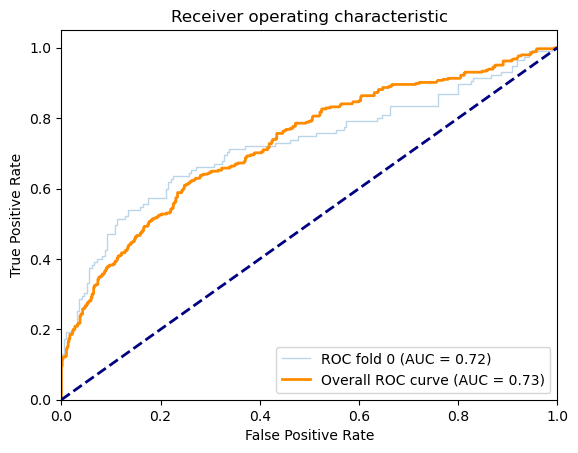

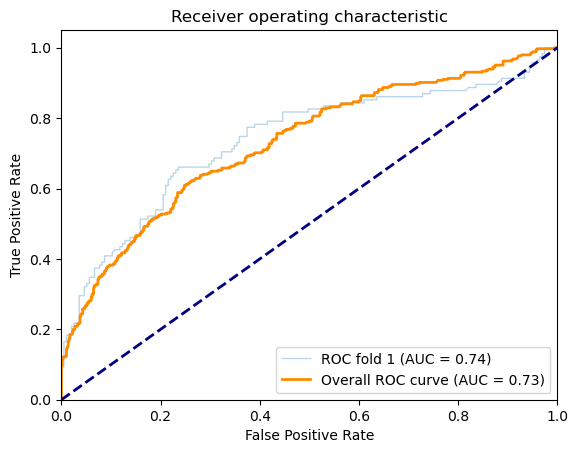

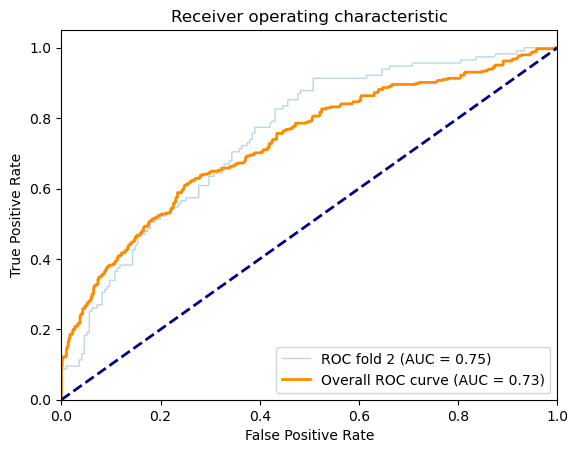

In [20]:
cnn.summary()
# Compute the overall ROC curve and AUC for all the folds
y_true = np.concatenate(y_true_list)
y_proba = np.concatenate(yhat_list)
fpr, tpr, thresholds = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve for each fold and the overall ROC curve
plt.figure()
for i in range(len(fpr_list)):
    plt.plot(fpr_list[i], tpr_list[i], lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, auc_list[i]))
    plt.plot(fpr, tpr, lw=2, color='darkorange', label='Overall ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

10/10 [==============================] - 0s 4ms/step
CPU times: user 45.7 s, sys: 8.05 s, total: 53.8 s
Wall time: 41 s


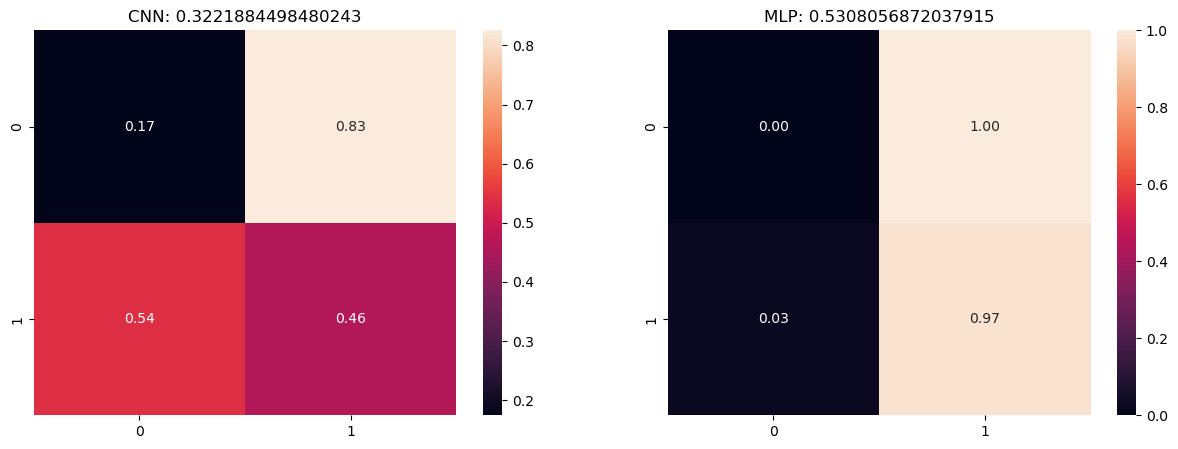

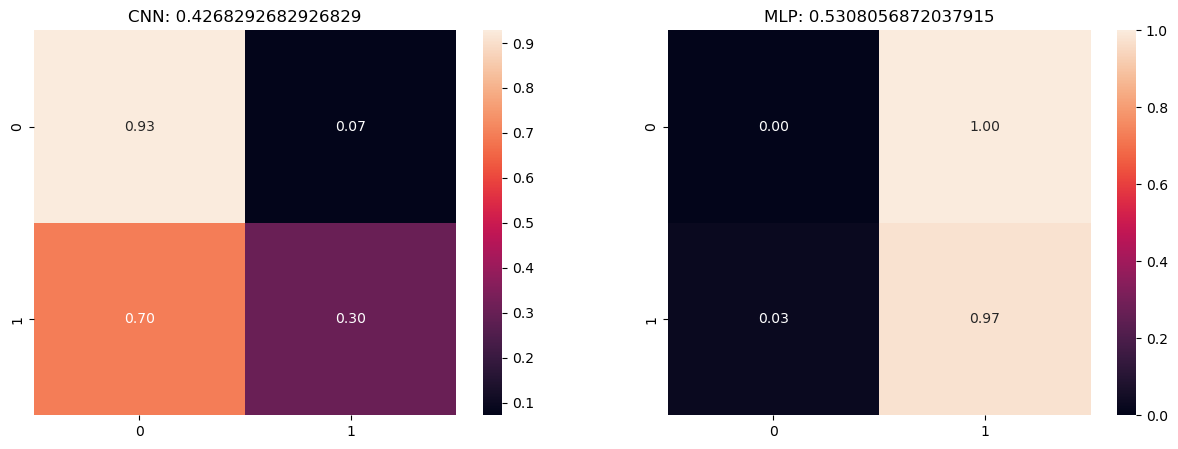

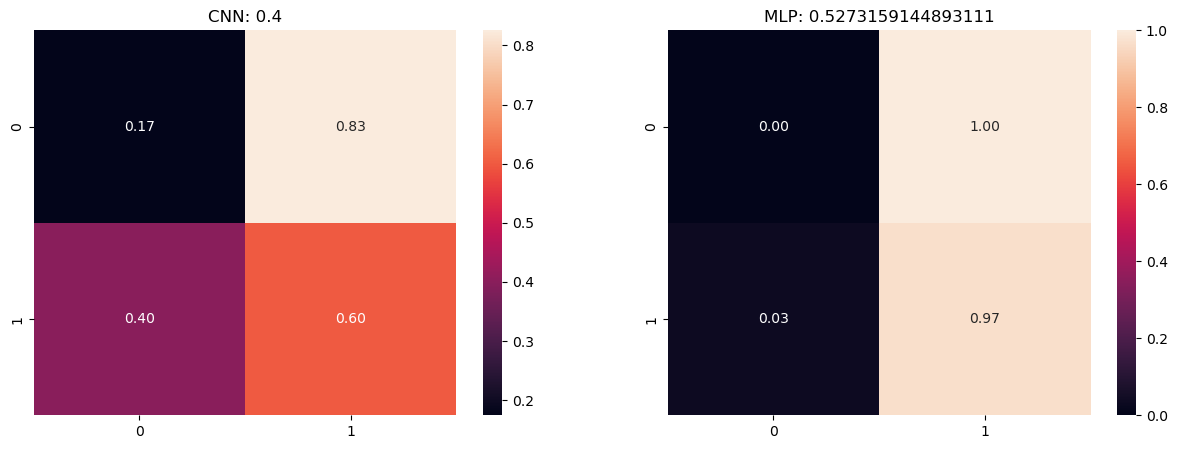

In [34]:
%%time

# Initialize lists to store the true and predicted labels and the ROC curve data\n",
y_true_list = []
yhat_list = []
fpr_list = []
tpr_list = []
auc_list = []

# changes: 
#    1. increased kernel size
cnn2 = Sequential()
cnn2.add( Conv2D(filters=16, kernel_size= (3, 3), 
                padding='same', input_shape=(192,192,1),
                ) )
cnn2.add( Activation('relu') )
cnn2.add( MaxPooling2D(pool_size=(2, 2)) )
# add one layer on flattened output
cnn2.add( Flatten() )
cnn2.add( Dense(NUM_CLASSES, activation='softmax') )

# Let's train the model 
cnn2.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

for train_index, test_index in sss.split(images, targets):
    X_train, X_test = images[train_index], images[test_index]
    y_train, y_test = targets[train_index], targets[test_index]
    
    cnn2.fit(X_train, y_train, 
            batch_size=32, epochs=50, 
            shuffle=False, verbose=0)

    compare_mlp_cnn(cnn2,mlp,X_test,y_test)
    
    yhat_proba = cnn2.predict(X_test)
    final_yhat = []
    for sample in yhat_proba:
        if sample[0] > sample[1]:
            final_yhat.append(sample[0])
        else:
            final_yhat.append(sample[1])
    # Compute the ROC curve and AUC for the current fold
    fpr, tpr, thresholds = roc_curve(y_test, final_yhat)
    roc_auc = auc(fpr, tpr)

    # Append the true labels, predicted probabilities, and ROC curve data to the lists
    y_true_list.append(y_test)
    yhat_list.append(final_yhat)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(roc_auc)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 192, 192, 16)      160       
                                                                 
 activation_25 (Activation)  (None, 192, 192, 16)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 96, 96, 16)       0         
 2D)                                                             
                                                                 
 flatten_9 (Flatten)         (None, 147456)            0         
                                                                 
 dense_30 (Dense)            (None, 2)                 294914    
                                                                 
Total params: 295,074
Trainable params: 295,074
Non-trainable params: 0
_______________________________________________

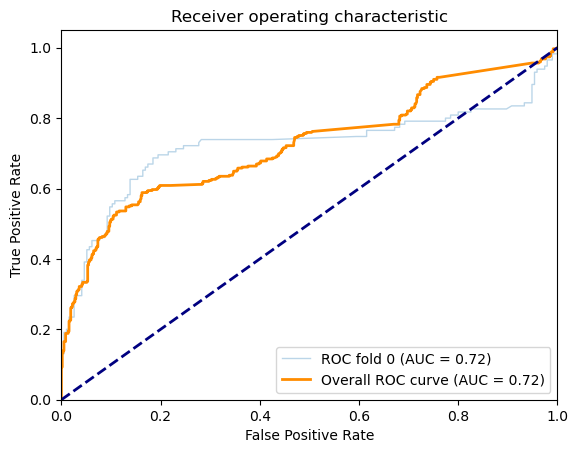

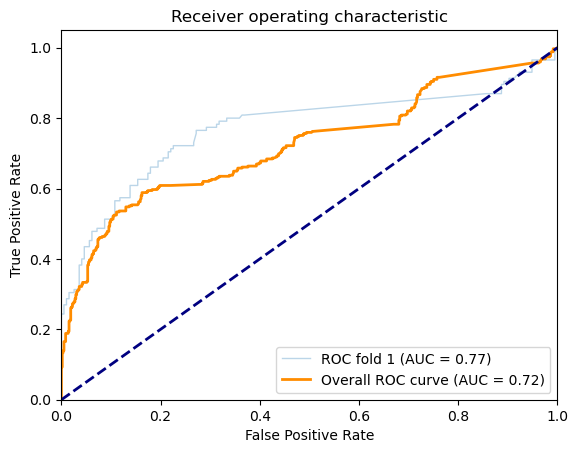

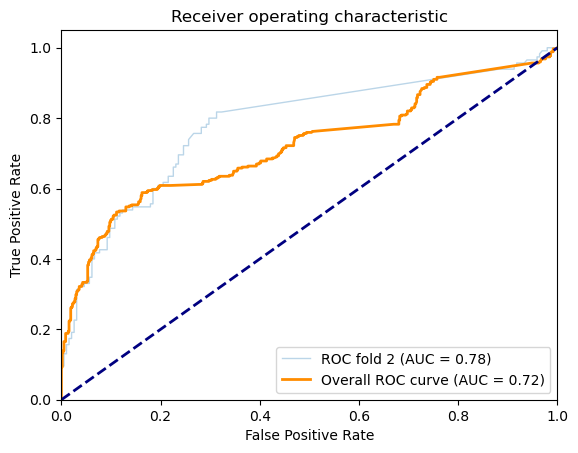

In [35]:
cnn2.summary()
# Compute the overall ROC curve and AUC for all the folds
y_true = np.concatenate(y_true_list)
y_proba = np.concatenate(yhat_list)
fpr, tpr, thresholds = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve for each fold and the overall ROC curve
plt.figure()
for i in range(len(fpr_list)):
    plt.plot(fpr_list[i], tpr_list[i], lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, auc_list[i]))
    plt.plot(fpr, tpr, lw=2, color='darkorange', label='Overall ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

10/10 [==============================] - 0s 4ms/step
CPU times: user 1min 2s, sys: 14.2 s, total: 1min 17s
Wall time: 1min 5s


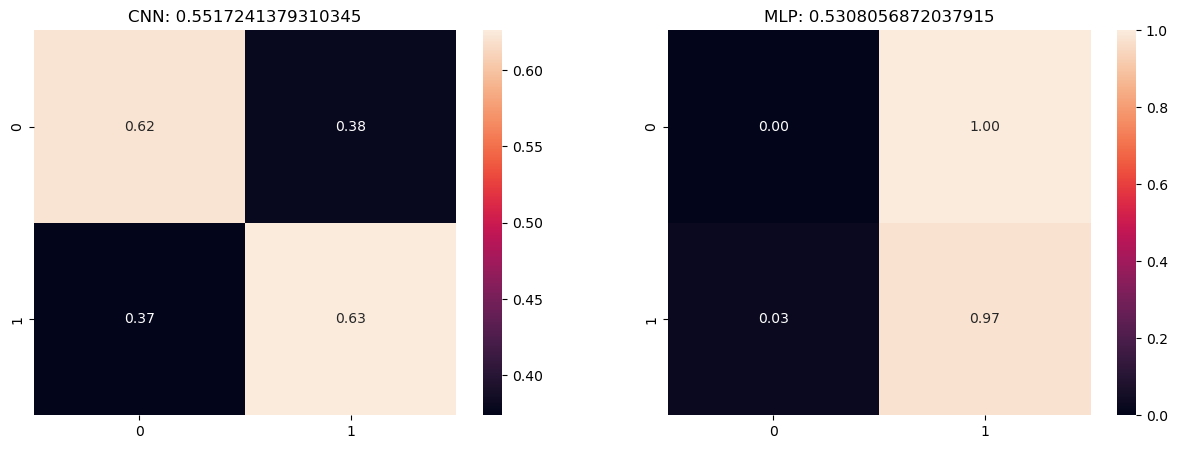

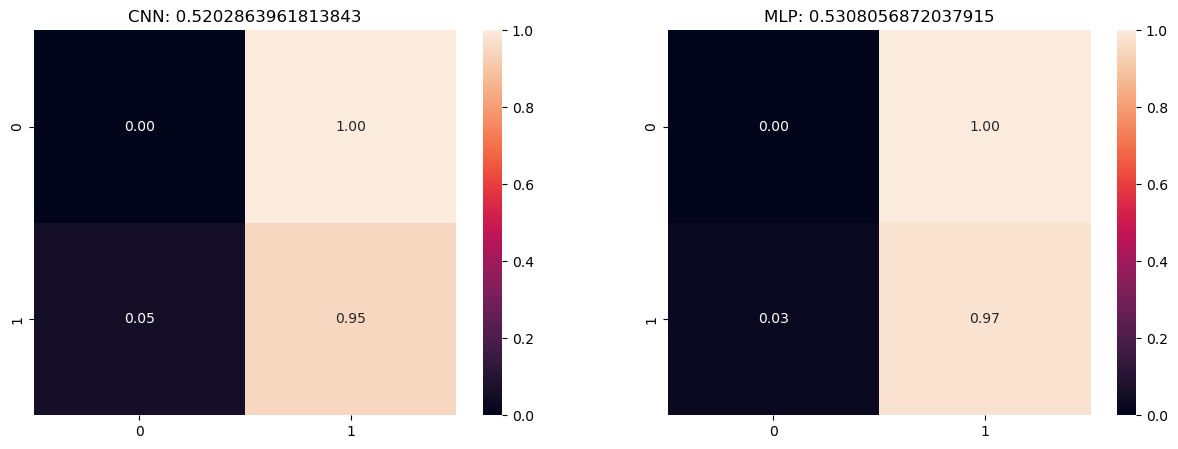

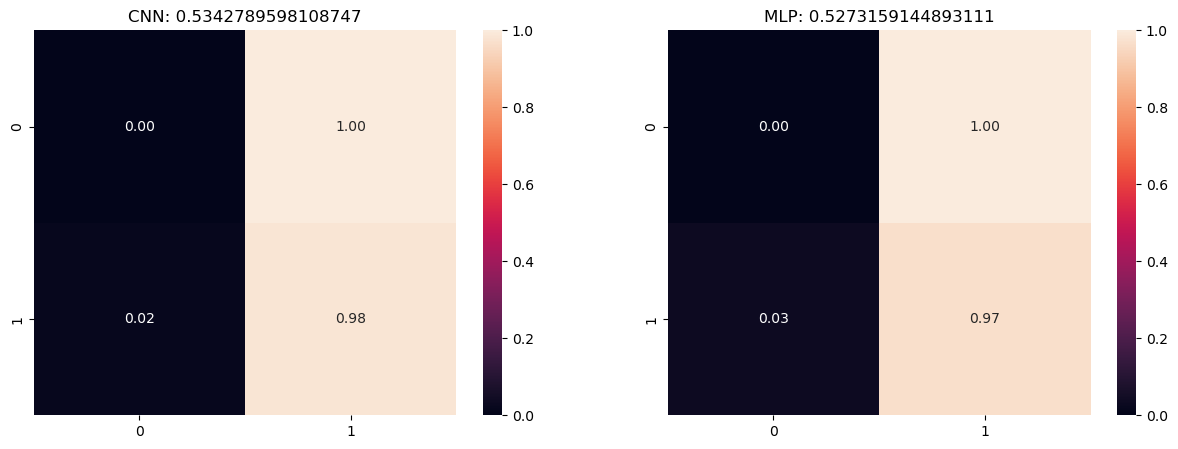

In [36]:
%%time

# Initialize lists to store the true and predicted labels and the ROC curve data\n",
y_true_list = []
yhat_list = []
fpr_list = []
tpr_list = []
auc_list = []

# changes: 
#    1. increased kernel size
#    2. add another conv/pool layer 
cnn3 = Sequential()

num_filt_layers = [32, 32]
for num_filters in num_filt_layers:
    cnn3.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same', input_shape=(192,192,1),
                     ) )
    cnn3.add( Activation('relu'))
    cnn3.add( MaxPooling2D(pool_size=(2, 2)) )
    

# add one layer on flattened output
cnn3.add( Flatten() )
cnn3.add( Dense(NUM_CLASSES) )
cnn3.add( Activation('softmax') )

# Let's train the model 
cnn3.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

for train_index, test_index in sss.split(images, targets):
    X_train, X_test = images[train_index], images[test_index]
    y_train, y_test = targets[train_index], targets[test_index]
    
    cnn3.fit(X_train, y_train, 
            batch_size=32, epochs=50, 
            shuffle=False, verbose=0)

    compare_mlp_cnn(cnn3,mlp,X_test,y_test)
    
    yhat_proba = cnn3.predict(X_test)
    final_yhat = []
    for sample in yhat_proba:
        if sample[0] > sample[1]:
            final_yhat.append(sample[0])
        else:
            final_yhat.append(sample[1])
    # Compute the ROC curve and AUC for the current fold
    fpr, tpr, thresholds = roc_curve(y_test, final_yhat)
    roc_auc = auc(fpr, tpr)

    # Append the true labels, predicted probabilities, and ROC curve data to the lists
    y_true_list.append(y_test)
    yhat_list.append(final_yhat)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(roc_auc)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 192, 192, 32)      320       
                                                                 
 activation_26 (Activation)  (None, 192, 192, 32)      0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 96, 96, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 activation_27 (Activation)  (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                 

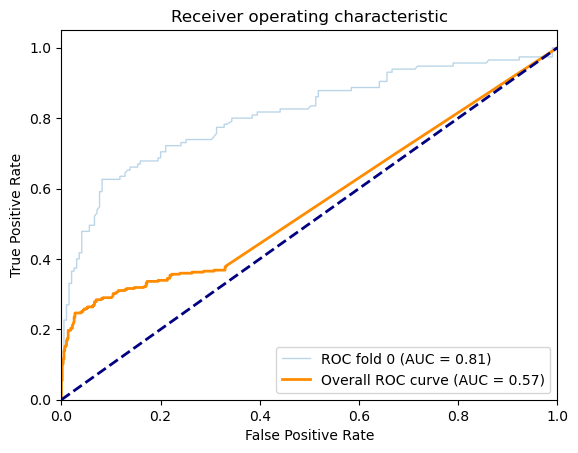

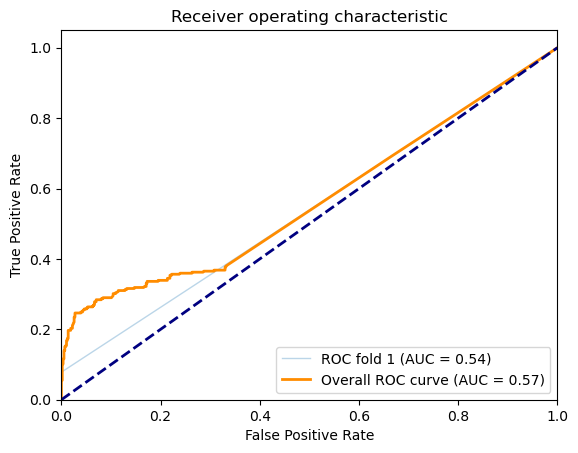

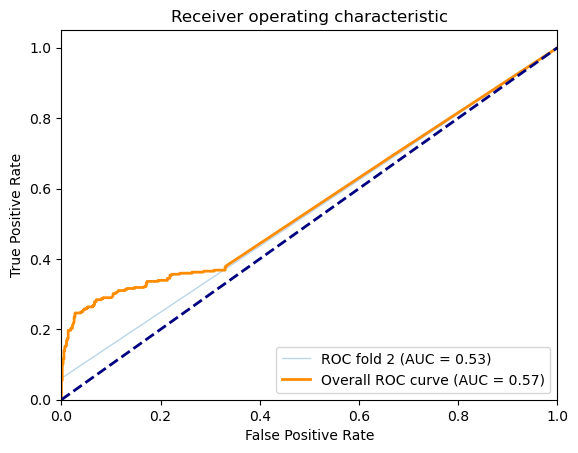

In [37]:
cnn3.summary()
# Compute the overall ROC curve and AUC for all the folds
y_true = np.concatenate(y_true_list)
y_proba = np.concatenate(yhat_list)
fpr, tpr, thresholds = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve for each fold and the overall ROC curve
plt.figure()
for i in range(len(fpr_list)):
    plt.plot(fpr_list[i], tpr_list[i], lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, auc_list[i]))
    plt.plot(fpr, tpr, lw=2, color='darkorange', label='Overall ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

10/10 [==============================] - 0s 3ms/step
CPU times: user 57.8 s, sys: 11.6 s, total: 1min 9s
Wall time: 57.5 s


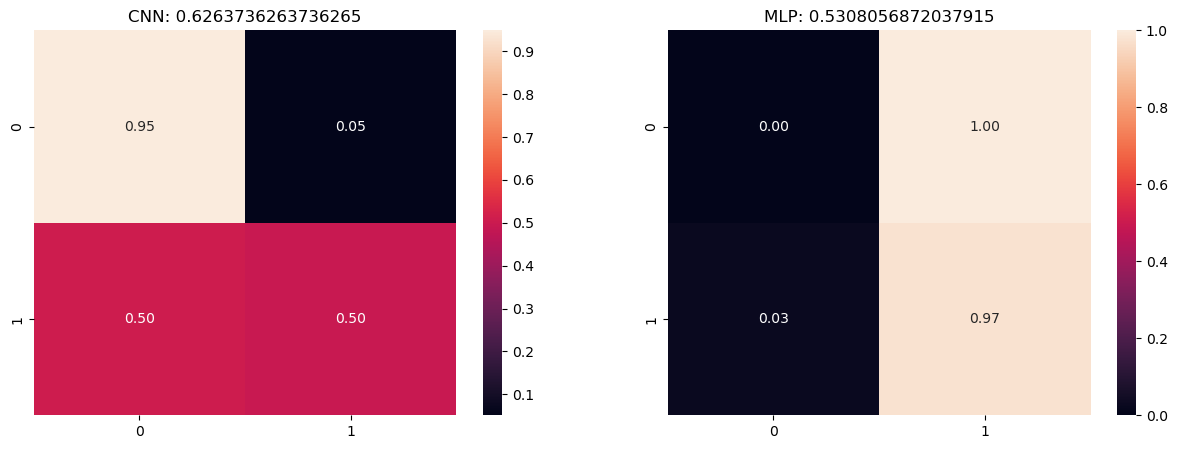

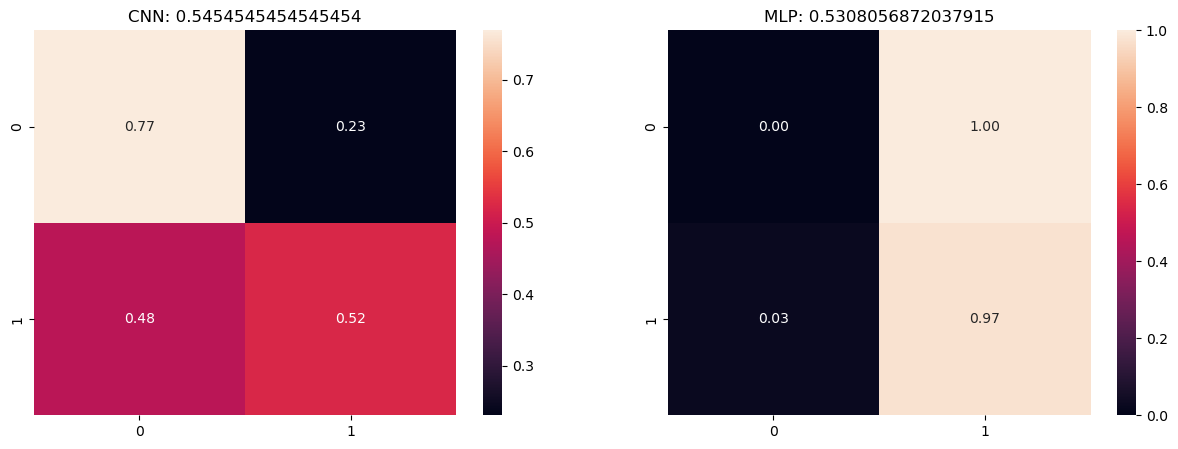

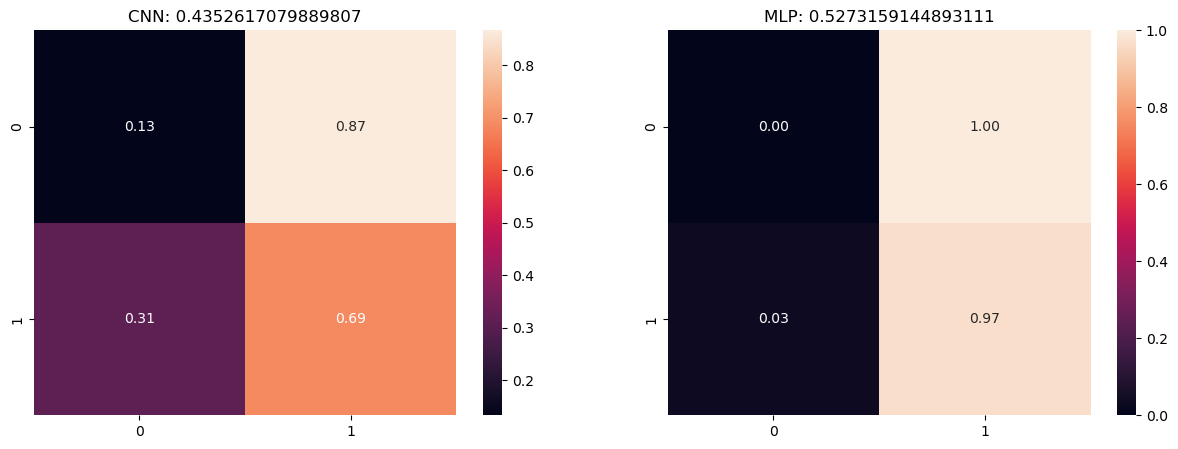

In [38]:
%%time

# Initialize lists to store the true and predicted labels and the ROC curve data\n",
y_true_list = []
yhat_list = []
fpr_list = []
tpr_list = []
auc_list = []

# changes: 
#    1. increased kernel size
#    2. add another conv/pool layer with increasing num filters
#    3. add more layers once flattened
cnn4 = Sequential()

num_filt_layers = [16, 32]
for num_filters in num_filt_layers:
    cnn4.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same', input_shape=(192,192,1),
                    ) )
    cnn4.add( Activation('relu'))
    cnn4.add( MaxPooling2D(pool_size=(2, 2)))
    

# add one layer on flattened output
cnn4.add( Flatten() )
cnn4.add( Dense(100) )
cnn4.add( Activation('relu') )
cnn4.add( Dense(NUM_CLASSES) )
cnn4.add( Activation('softmax') )

# Let's train the model 
cnn4.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

for train_index, test_index in sss.split(images, targets):
    X_train, X_test = images[train_index], images[test_index]
    y_train, y_test = targets[train_index], targets[test_index]
    
    cnn4.fit(X_train, y_train, 
            batch_size=32, epochs=50, 
            shuffle=False, verbose=0)

    compare_mlp_cnn(cnn4,mlp,X_test,y_test)
    
    yhat_proba = cnn4.predict(X_test)
    final_yhat = []
    for sample in yhat_proba:
        if sample[0] > sample[1]:
            final_yhat.append(sample[0])
        else:
            final_yhat.append(sample[1])
    # Compute the ROC curve and AUC for the current fold
    fpr, tpr, thresholds = roc_curve(y_test, final_yhat)
    roc_auc = auc(fpr, tpr)

    # Append the true labels, predicted probabilities, and ROC curve data to the lists
    y_true_list.append(y_test)
    yhat_list.append(final_yhat)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(roc_auc)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 192, 192, 16)      160       
                                                                 
 activation_29 (Activation)  (None, 192, 192, 16)      0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 96, 96, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 96, 96, 32)        4640      
                                                                 
 activation_30 (Activation)  (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                

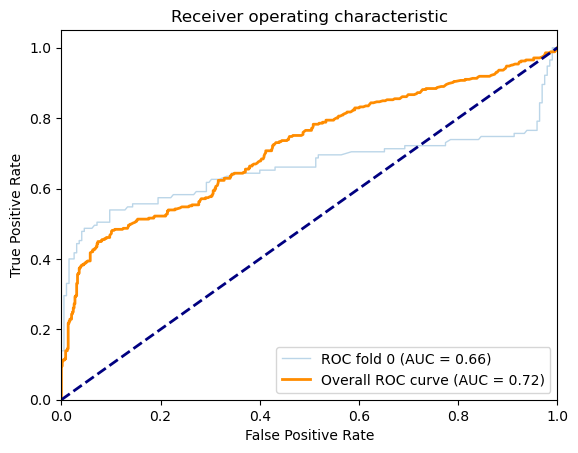

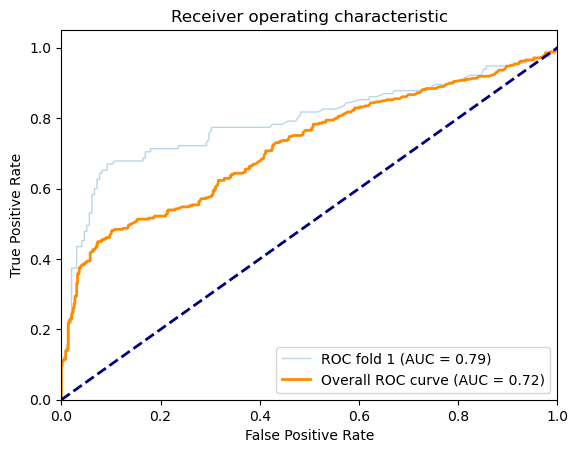

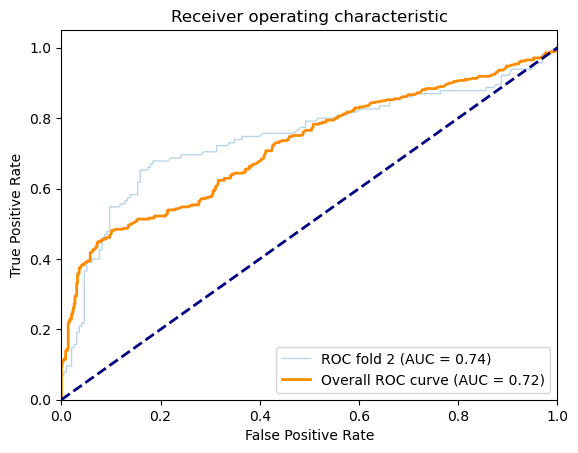

In [39]:
cnn4.summary()
# Compute the overall ROC curve and AUC for all the folds
y_true = np.concatenate(y_true_list)
y_proba = np.concatenate(yhat_list)
fpr, tpr, thresholds = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve for each fold and the overall ROC curve
plt.figure()
for i in range(len(fpr_list)):
    plt.plot(fpr_list[i], tpr_list[i], lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, auc_list[i]))
    plt.plot(fpr, tpr, lw=2, color='darkorange', label='Overall ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

## Analysis (ROC & Interpretation)
Now that we've had a chance to examine the preformance of our CNNs against the MLP across several different configurations, let's take a look at the most preformant version and compare it against the standard multi-layer preceptron using ROC, or the reciever operating characteristic.

### Transfer Learning

In [44]:
%%time

# Initialize lists to store the true and predicted labels and the ROC curve data\n",
y_true_list = []
yhat_list = []
fpr_list = []
tpr_list = []
auc_list = []

NUM_CLASSES = 2

base_model = ResNet50(weights='imagenet', include_top=False)
cnn5 = Sequential()
cnn5.add(base_model)
cnn5.add(GlobalAveragePooling2D())

# Add dense layers
cnn5.add(Dense(100))
cnn5.add(Activation('relu'))
cnn5.add(Dense(NUM_CLASSES))
cnn5.add(Activation('softmax'))

cnn5.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# ResNet expects 3 channels, so convert to 3 from 1
X_3_channels = np.stack([images] * 3, axis=-1)

for train_index, test_index in sss.split(X_3_channels, targets):
    X_train, X_test = X_3_channels[train_index], X_3_channels[test_index]
    y_train, y_test = targets[train_index], targets[test_index]
    
    cnn5.fit(X_train, y_train, 
            batch_size=32, epochs=50, 
            shuffle=False, verbose=False)
    
    yhat_proba = cnn5.predict(X_test)
    final_yhat = []
    for sample in yhat_proba:
        if sample[0] > sample[1]:
            final_yhat.append(sample[0])
        else:
            final_yhat.append(sample[1])
    # Compute the ROC curve and AUC for the current fold
    fpr, tpr, thresholds = roc_curve(y_test, final_yhat)
    roc_auc = auc(fpr, tpr)

    # Append the true labels, predicted probabilities, and ROC curve data to the lists
    y_true_list.append(y_test)
    yhat_list.append(final_yhat)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(roc_auc)

10/10 [==============================] - 0s 39ms/step
CPU times: user 8min 34s, sys: 1min 51s, total: 10min 25s
Wall time: 12min 42s


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d_7   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_38 (Dense)            (None, 100)               204900    
                                                                 
 activation_37 (Activation)  (None, 100)               0         
                                                                 
 dense_39 (Dense)            (None, 2)                 202       
                                                                 
 activation_38 (Activation)  (None, 2)                 0         
                                                     

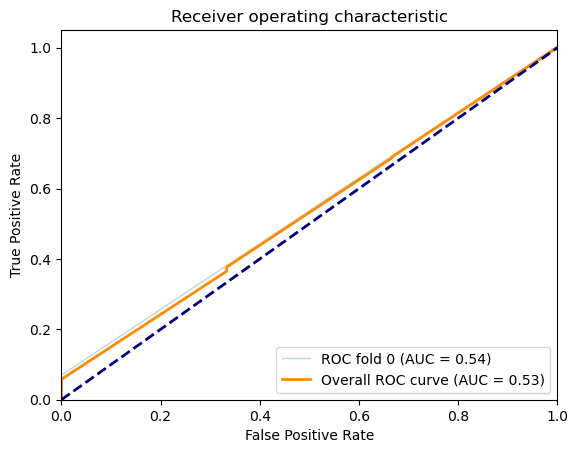

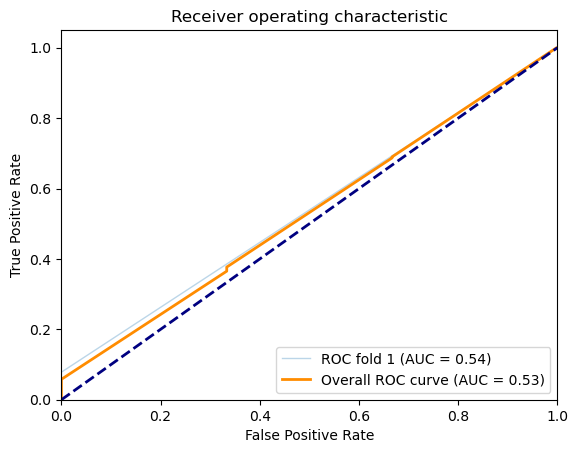

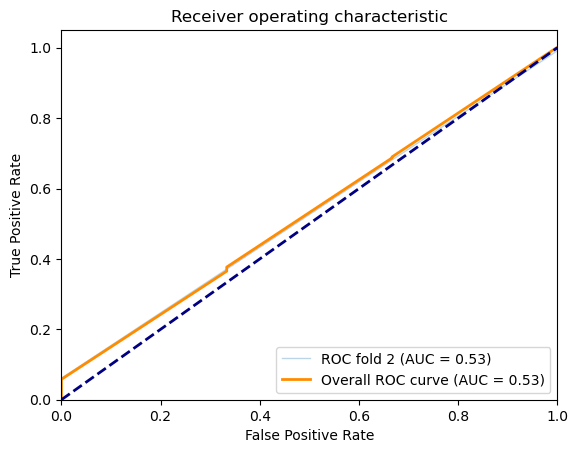

In [ ]:
cnn5.summary()
# Compute the overall ROC curve and AUC for all the folds
y_true = np.concatenate(y_true_list)
y_proba = np.concatenate(yhat_list)
fpr, tpr, thresholds = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve for each fold and the overall ROC curve
plt.figure()
for i in range(len(fpr_list)):
    plt.plot(fpr_list[i], tpr_list[i], lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, auc_list[i]))
    plt.plot(fpr, tpr, lw=2, color='darkorange', label='Overall ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()